<a href="https://colab.research.google.com/github/Nithira17/PR-Project/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import EMNIST
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

## Load the emnist dataset
Download and load the EMNIST dataset using torchvision's `datasets` module.


In [62]:
data_root = './data'
os.makedirs(data_root, exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

emnist_dataset = EMNIST(root=data_root, split='mnist', download=True, transform=transform)

### Visualize a few images


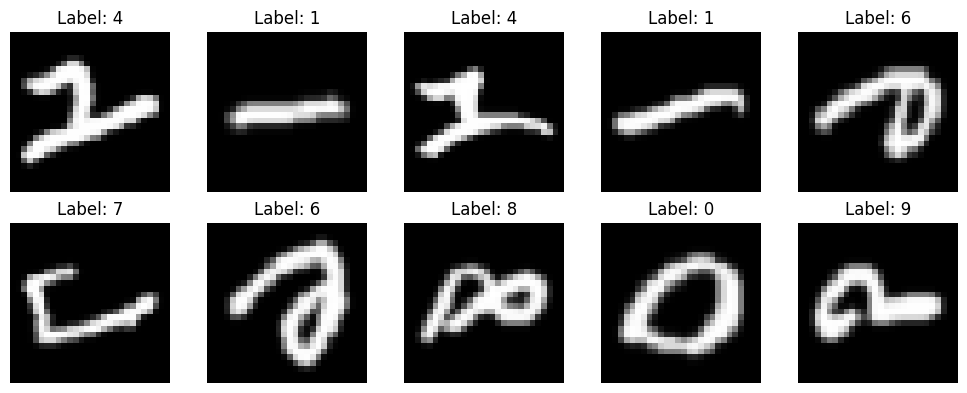

In [63]:
emnist_dataset_viz = EMNIST(root=data_root, split='mnist', download=True, transform=transforms.ToTensor())

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.flatten()

for i in range(10):
    img, label = emnist_dataset_viz[i]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [64]:
# Set a seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# Define the split ratios (e.g., 70% train, 15% validation, 15% test)
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Calculate the number of samples for each split
total_samples = len(emnist_dataset)
train_samples = int(total_samples * train_ratio)
val_samples = int(total_samples * val_ratio)
test_samples = total_samples - train_samples - val_samples # Ensure all samples are included

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    emnist_dataset,
    [train_samples, val_samples, test_samples],
    generator=torch.Generator().manual_seed(seed) # Use the same seed for the generator
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 42000
Validation dataset size: 9000
Test dataset size: 9000


In [65]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [66]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Build CNN Model

In [67]:
class CustomCNN(nn.Module):
  def __init__(self, num_classes=10):
    super(CustomCNN, self).__init__()

    # Convolutional layers
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.relu1 = nn.ReLU()
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.relu2 = nn.ReLU()
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    # Fully connected layers
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(64 * 7 * 7, 128)
    self.relu3 = nn.ReLU()
    self.dropout = nn.Dropout(0.5)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Conv block 2
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x


## Training

In [68]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [69]:
def validate(model, val_loader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(val_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [70]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs, device):
    """Complete training loop"""
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion,
                                           optimizer, device)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 60)

    return train_losses, val_losses, train_accs, val_accs

## Optimizer Comparison

In [71]:
def find_learning_rate(model, train_loader, device, lr_min=1e-6, lr_max=1e-1):
    """
    Simple learning rate finder (optional utility)
    Trains for one epoch with exponentially increasing learning rate
    """
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr_min)

    lrs = []
    losses = []

    lr_mult = (lr_max / lr_min) ** (1/len(train_loader))

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        lrs.append(optimizer.param_groups[0]['lr'])
        losses.append(loss.item())

        # Update learning rate
        for param_group in optimizer.param_groups:
            param_group['lr'] *= lr_mult

        if loss.item() > 4 * min(losses):  # Stop if loss explodes
            break

    return lrs, losses

In [72]:
def compare_optimizers():
    results = {}
    num_epochs = 20

    # 1. Adam Optimizer
    print("\n" + "="*60)
    print("Training with Adam Optimizer")
    print("="*60)
    model_adam = CustomCNN(num_classes=10).to(device)
    optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses_adam, val_losses_adam, train_accs_adam, val_accs_adam = \
        train_model(model_adam, train_loader, val_loader, criterion,
                   optimizer_adam, num_epochs, device)

    results['Adam'] = {
        'model': model_adam,
        'train_losses': train_losses_adam,
        'val_losses': val_losses_adam,
        'train_accs': train_accs_adam,
        'val_accs': val_accs_adam
    }

    # 2. SGD (Standard)
    print("\n" + "="*60)
    print("Training with Standard SGD")
    print("="*60)
    model_sgd = CustomCNN(num_classes=10).to(device)
    optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01)

    train_losses_sgd, val_losses_sgd, train_accs_sgd, val_accs_sgd = \
        train_model(model_sgd, train_loader, val_loader, criterion,
                   optimizer_sgd, num_epochs, device)

    results['SGD'] = {
        'model': model_sgd,
        'train_losses': train_losses_sgd,
        'val_losses': val_losses_sgd,
        'train_accs': train_accs_sgd,
        'val_accs': val_accs_sgd
    }

    # 3. SGD with Momentum
    print("\n" + "="*60)
    print("Training with SGD + Momentum")
    print("="*60)
    model_sgd_momentum = CustomCNN(num_classes=10).to(device)
    optimizer_sgd_momentum = optim.SGD(model_sgd_momentum.parameters(),
                                       lr=0.01, momentum=0.9)

    train_losses_momentum, val_losses_momentum, train_accs_momentum, val_accs_momentum = \
        train_model(model_sgd_momentum, train_loader, val_loader, criterion,
                   optimizer_sgd_momentum, num_epochs, device)

    results['SGD_Momentum'] = {
        'model': model_sgd_momentum,
        'train_losses': train_losses_momentum,
        'val_losses': val_losses_momentum,
        'train_accs': train_accs_momentum,
        'val_accs': val_accs_momentum
    }

    return results

## Evaluation

In [73]:
def evaluate_model(model, test_loader, device):
    """
    Question 12: Model Evaluation
    Computes: Accuracy, Confusion Matrix, Precision, Recall
    """
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accuracy = 100. * correct / total

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Classification Report (includes precision, recall, F1-score)
    report = classification_report(all_labels, all_preds,
                                   target_names=[str(i) for i in range(10)])

    return accuracy, cm, report

In [74]:
def plot_training_curves(results):
    """Plot training and validation curves for all optimizers"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss curves
    for name, data in results.items():
        axes[0, 0].plot(data['train_losses'], label=f'{name} Train')
        axes[0, 1].plot(data['val_losses'], label=f'{name} Val')

    axes[0, 0].set_title('Training Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    axes[0, 1].set_title('Validation Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Accuracy curves
    for name, data in results.items():
        axes[1, 0].plot(data['train_accs'], label=f'{name} Train')
        axes[1, 1].plot(data['val_accs'], label=f'{name} Val')

    axes[1, 0].set_title('Training Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    axes[1, 1].set_title('Validation Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

In [75]:
def plot_confusion_matrix(cm, title='Confusion Matrix'):
    """Plot confusion matrix"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'{title.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

Starting optimizer comparison...

Training with Adam Optimizer
Epoch [1/20]
Train Loss: 0.2478, Train Acc: 92.38%
Val Loss: 0.0594, Val Acc: 98.16%
------------------------------------------------------------
Epoch [2/20]
Train Loss: 0.0870, Train Acc: 97.51%
Val Loss: 0.0477, Val Acc: 98.59%
------------------------------------------------------------
Epoch [3/20]
Train Loss: 0.0644, Train Acc: 98.09%
Val Loss: 0.0409, Val Acc: 98.72%
------------------------------------------------------------
Epoch [4/20]
Train Loss: 0.0531, Train Acc: 98.50%
Val Loss: 0.0348, Val Acc: 98.96%
------------------------------------------------------------
Epoch [5/20]
Train Loss: 0.0472, Train Acc: 98.60%
Val Loss: 0.0300, Val Acc: 99.13%
------------------------------------------------------------
Epoch [6/20]
Train Loss: 0.0393, Train Acc: 98.82%
Val Loss: 0.0330, Val Acc: 99.03%
------------------------------------------------------------
Epoch [7/20]
Train Loss: 0.0332, Train Acc: 98.98%
Val Loss: 

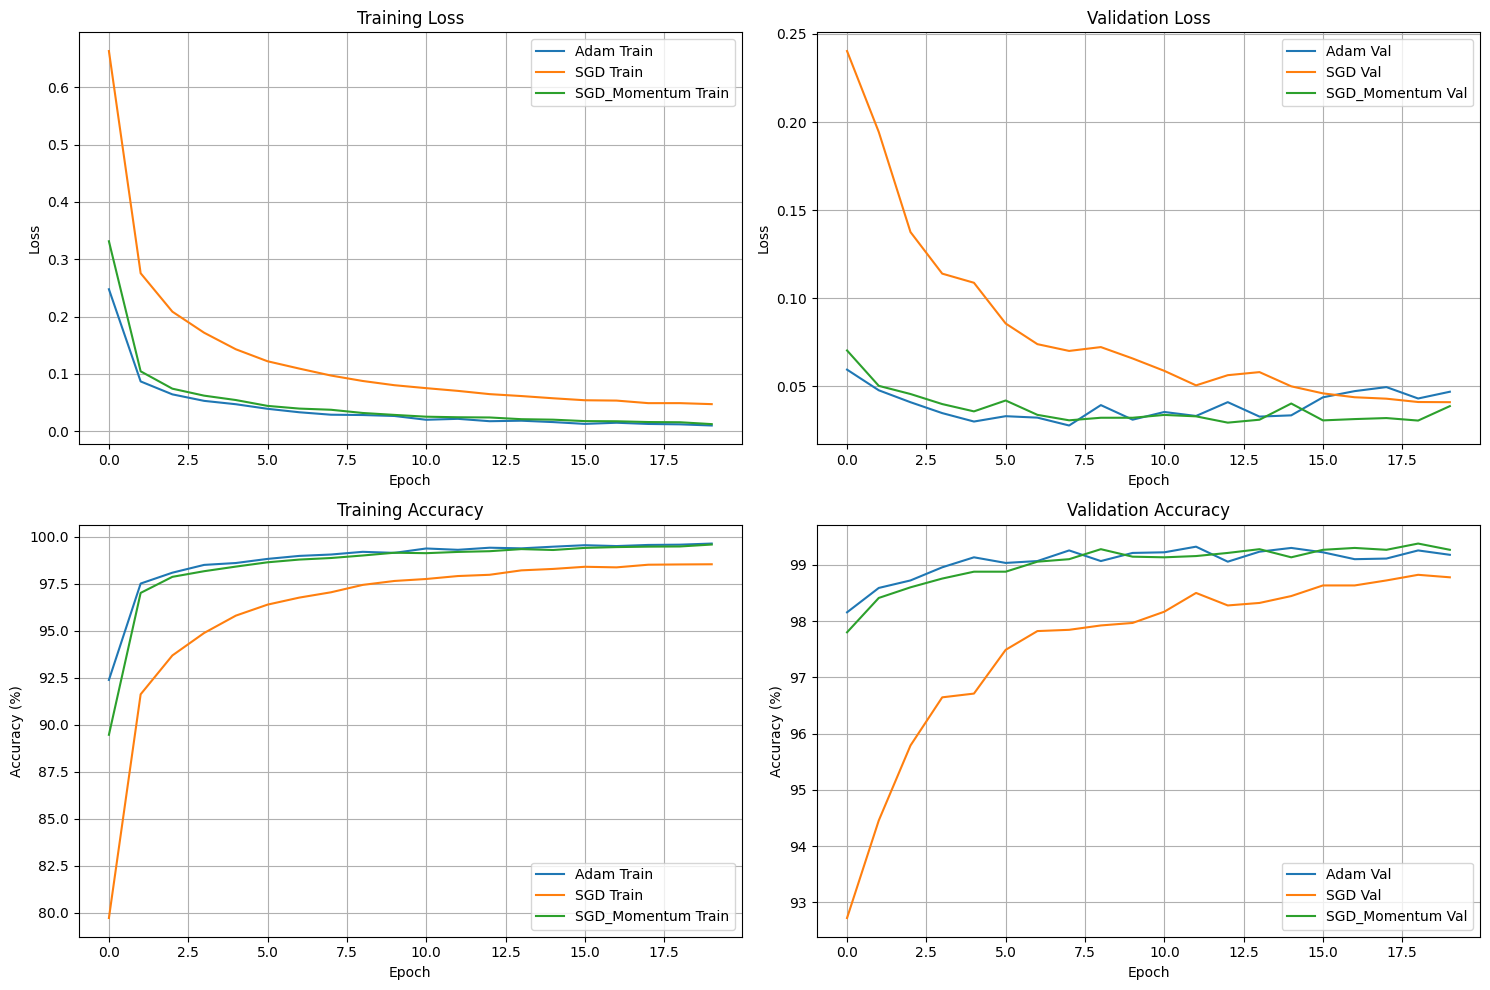


FINAL EVALUATION ON TEST SET

Adam Optimizer:
Test Accuracy: 99.31%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       886
           1       1.00      1.00      1.00       909
           2       0.99      0.99      0.99       860
           3       1.00      0.99      0.99       911
           4       1.00      1.00      1.00       895
           5       0.99      1.00      0.99       924
           6       1.00      0.99      0.99       887
           7       0.99      0.99      0.99       938
           8       0.99      0.99      0.99       876
           9       0.99      0.99      0.99       914

    accuracy                           0.99      9000
   macro avg       0.99      0.99      0.99      9000
weighted avg       0.99      0.99      0.99      9000



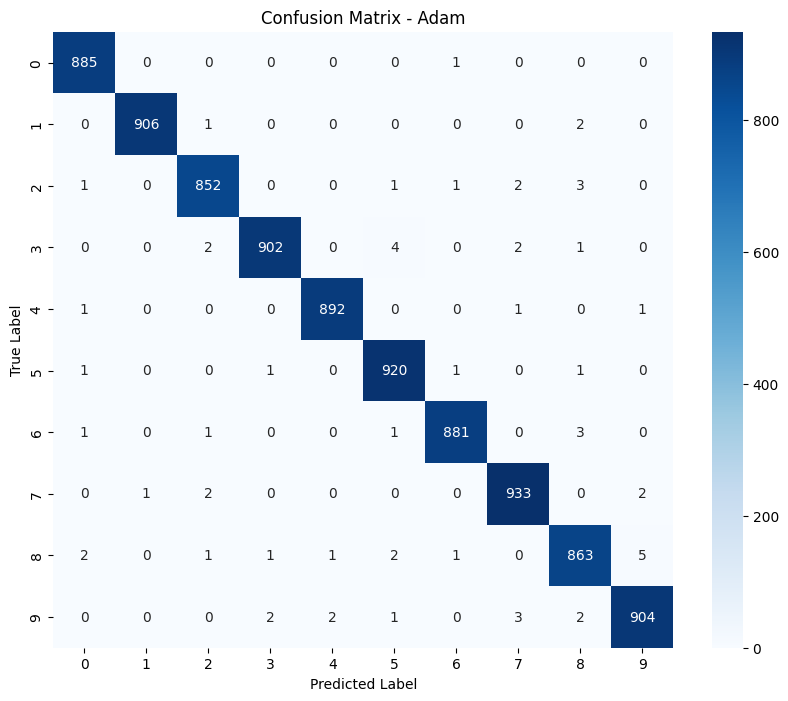


SGD Optimizer:
Test Accuracy: 98.82%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       886
           1       0.99      0.99      0.99       909
           2       0.99      0.99      0.99       860
           3       0.99      0.98      0.99       911
           4       0.99      0.99      0.99       895
           5       0.98      0.99      0.99       924
           6       0.99      1.00      0.99       887
           7       0.99      0.99      0.99       938
           8       0.99      0.98      0.98       876
           9       0.97      0.99      0.98       914

    accuracy                           0.99      9000
   macro avg       0.99      0.99      0.99      9000
weighted avg       0.99      0.99      0.99      9000



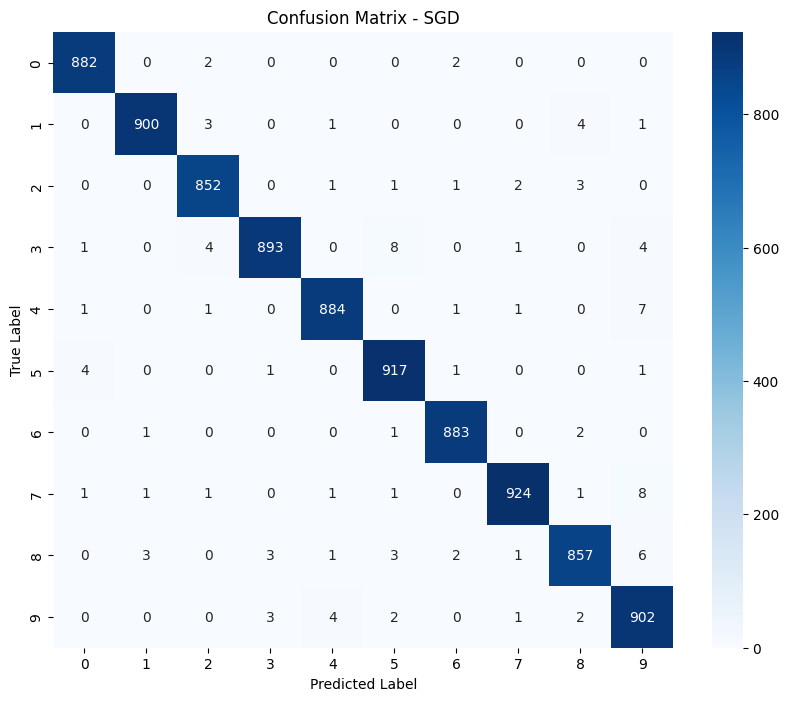


SGD_Momentum Optimizer:
Test Accuracy: 99.28%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       886
           1       1.00      1.00      1.00       909
           2       1.00      0.99      0.99       860
           3       1.00      0.99      0.99       911
           4       0.99      1.00      1.00       895
           5       0.98      1.00      0.99       924
           6       0.99      1.00      1.00       887
           7       1.00      0.99      0.99       938
           8       0.99      0.99      0.99       876
           9       0.98      0.99      0.99       914

    accuracy                           0.99      9000
   macro avg       0.99      0.99      0.99      9000
weighted avg       0.99      0.99      0.99      9000



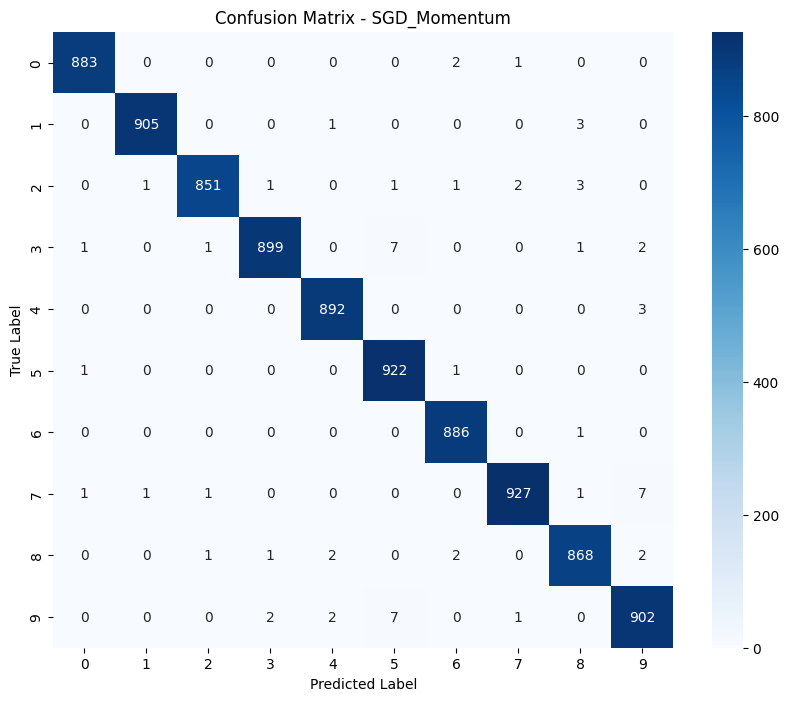


Training Complete! Check saved plots.


In [76]:
if __name__ == "__main__":
    # Train and compare optimizers
    print("Starting optimizer comparison...")
    results = compare_optimizers()

    # Plot training curves
    print("\nPlotting training curves...")
    plot_training_curves(results)

    # Evaluate each model on test set
    print("\n" + "="*60)
    print("FINAL EVALUATION ON TEST SET")
    print("="*60)

    for name, data in results.items():
        print(f"\n{name} Optimizer:")
        accuracy, cm, report = evaluate_model(data['model'], test_loader, device)
        print(f"Test Accuracy: {accuracy:.2f}%")
        print("\nClassification Report:")
        print(report)
        plot_confusion_matrix(cm, title=f'Confusion Matrix - {name}')

    print("\n" + "="*60)
    print("Training Complete! Check saved plots.")
    print("="*60)